In [1]:
%load_ext autoreload
%autoreload 2    

In [2]:
import csv
from torchvision import datasets, models, transforms
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

from augmentation import *
from train import train, train_transfer
from config.transfer_config import *

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
IMG_SIZE = 300

In [5]:
transforms_auto = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE), antialias=True),
                                      transforms.AutoAugment(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # For the Imagenet Transfer learning
                              
                                     ])
transforms_auto_test = transforms.Compose([transforms.ToTensor(),
                                           transforms.Resize((IMG_SIZE,IMG_SIZE), antialias=True),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # For the Imagenet Transfer learning
                              
                                          ])

In [6]:
trainset = datasets.ImageFolder('/dtu/datasets1/02514/hotdog_nothotdog/train', transform=transforms_auto)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)

testset = datasets.ImageFolder('/dtu/datasets1/02514/hotdog_nothotdog/test', transform=transforms_auto_test)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)

In [7]:
images, targets = next(iter(test_loader))

In [8]:
def denormalize(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    denormalize = transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                         std=[1/0.229, 1/0.224, 1/0.225])

    denorm_image = denormalize(img)
    x = ((denorm_image - denorm_image.min())/(denorm_image - denorm_image.min()).max() * 255).to(torch.int64)
    return x

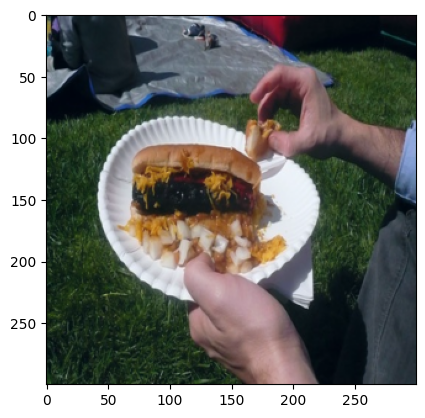

In [9]:
img = images[50] 
x = denormalize(img)
plt.imshow(x.permute(1,2,0))

# Options

1. training only the head with normal learning rate
2. training all with super low training rate

In [10]:
def transfer_model_set(model, freeze_convs=False,):
    
    if freeze_convs:
        print('Freezing Convs')
        # freeze the feature extractors
        for param in model.parameters():
            param.requires_grad = False
    
    if type(model) == torchvision.models.densenet.DenseNet:
        in_features = model.classifier.in_features
    
    elif type(model) == torchvision.models.resnet.ResNet:
        in_features = model.fc.in_features
    
    
    size_hidden = 512
    out_features = 1
    
    head = nn.Sequential(
                    nn.Linear(in_features, size_hidden),
                    nn.Dropout(DROP_OUT_RATE),
                    nn.ReLU(),
                    nn.BatchNorm1d(size_hidden),
                    nn.Linear(size_hidden, out_features),
                    nn.Sigmoid()        
    )
                    
    
    if type(model) == torchvision.models.densenet.DenseNet:
        model.classifier = head
    
    elif type(model) == torchvision.models.resnet.ResNet:
        model.fc = head

    else:
        raise Exception('Not implemented the classifier for this type of model')

    model = model.to(device)

    return model


# fixed parameters 
loss = nn.BCELoss() 

In [11]:
def set_optimizers():
    optimizers = {
        'ADAM':torch.optim.Adam,
        'SGD':torch.optim.SGD,
        'ADAMW':torch.optim.AdamW,
    }
    return optimizers 

# 1. Training just head

In [12]:
optimizers = set_optimizers()

In [13]:

for optim, optimizer in optimizers.items():
        
    
    model = models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2) # lets take v2 here 
    model = transfer_model_set(model, freeze_convs=True)
    
    optimizer = optimizer(model.parameters(), HEAD_LEARNING_RATE)
    
    out_dict_resnet50 = train_transfer(model,
                                       train_loader, 
                                       test_loader,
                                       loss,
                                       optimizer,
                                       NUM_EPOCHS,
                                       save_model=True, 
                                       model_name='resnet50_head_' + optim)
    
    # saving results
    d = out_dict_resnet50
    with open(f'results/results_transfer_resnet_head_{NUM_EPOCHS}_epochs_{HEAD_LEARNING_RATE:.0e}_lr_{optim}_optim.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(d.keys())
        writer.writerows(zip(*d.values()))

Freezing Convs


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.242	 test: 0.163	 Accuracy train: 89.9%	 test: 93.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.135	 test: 0.134	 Accuracy train: 94.8%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.119	 test: 0.125	 Accuracy train: 95.8%	 test: 95.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.090	 test: 0.127	 Accuracy train: 96.4%	 test: 94.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.074	 test: 0.119	 Accuracy train: 97.4%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.078	 test: 0.132	 Accuracy train: 97.3%	 test: 94.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.064	 test: 0.132	 Accuracy train: 97.9%	 test: 95.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.064	 test: 0.132	 Accuracy train: 97.4%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.069	 test: 0.130	 Accuracy train: 97.4%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.050	 test: 0.135	 Accuracy train: 98.0%	 test: 94.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.047	 test: 0.122	 Accuracy train: 98.2%	 test: 95.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.049	 test: 0.124	 Accuracy train: 98.4%	 test: 95.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.048	 test: 0.129	 Accuracy train: 98.1%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.039	 test: 0.125	 Accuracy train: 98.6%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.038	 test: 0.127	 Accuracy train: 99.0%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.043	 test: 0.137	 Accuracy train: 98.5%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.035	 test: 0.140	 Accuracy train: 98.6%	 test: 95.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.049	 test: 0.150	 Accuracy train: 98.2%	 test: 94.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.046	 test: 0.162	 Accuracy train: 98.5%	 test: 94.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.046	 test: 0.139	 Accuracy train: 98.3%	 test: 94.8%
Freezing Convs


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.688	 test: 0.627	 Accuracy train: 55.8%	 test: 78.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.534	 test: 0.471	 Accuracy train: 77.9%	 test: 84.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.468	 test: 0.399	 Accuracy train: 81.5%	 test: 86.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.412	 test: 0.358	 Accuracy train: 85.5%	 test: 86.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.375	 test: 0.329	 Accuracy train: 87.1%	 test: 87.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.350	 test: 0.306	 Accuracy train: 87.6%	 test: 88.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.339	 test: 0.291	 Accuracy train: 87.8%	 test: 88.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.310	 test: 0.276	 Accuracy train: 89.7%	 test: 89.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.305	 test: 0.262	 Accuracy train: 88.7%	 test: 90.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.291	 test: 0.252	 Accuracy train: 89.7%	 test: 90.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.276	 test: 0.244	 Accuracy train: 90.3%	 test: 90.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.265	 test: 0.234	 Accuracy train: 90.9%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.261	 test: 0.227	 Accuracy train: 90.6%	 test: 91.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.261	 test: 0.222	 Accuracy train: 90.0%	 test: 91.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.247	 test: 0.214	 Accuracy train: 91.1%	 test: 92.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.243	 test: 0.209	 Accuracy train: 91.5%	 test: 92.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.237	 test: 0.207	 Accuracy train: 91.6%	 test: 92.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.236	 test: 0.202	 Accuracy train: 91.0%	 test: 92.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.227	 test: 0.197	 Accuracy train: 92.0%	 test: 92.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.226	 test: 0.194	 Accuracy train: 91.7%	 test: 92.9%
Freezing Convs


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.246	 test: 0.158	 Accuracy train: 89.0%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.138	 test: 0.135	 Accuracy train: 94.5%	 test: 94.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.103	 test: 0.124	 Accuracy train: 96.1%	 test: 95.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.093	 test: 0.155	 Accuracy train: 96.2%	 test: 93.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.089	 test: 0.121	 Accuracy train: 96.6%	 test: 95.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.080	 test: 0.128	 Accuracy train: 97.4%	 test: 95.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.077	 test: 0.126	 Accuracy train: 96.9%	 test: 94.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.065	 test: 0.136	 Accuracy train: 97.6%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.066	 test: 0.130	 Accuracy train: 98.0%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.053	 test: 0.128	 Accuracy train: 98.1%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.072	 test: 0.131	 Accuracy train: 97.5%	 test: 95.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.050	 test: 0.125	 Accuracy train: 98.1%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.070	 test: 0.124	 Accuracy train: 97.5%	 test: 95.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.039	 test: 0.119	 Accuracy train: 98.7%	 test: 95.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.043	 test: 0.124	 Accuracy train: 98.3%	 test: 95.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.045	 test: 0.124	 Accuracy train: 98.5%	 test: 95.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.042	 test: 0.130	 Accuracy train: 98.7%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.051	 test: 0.125	 Accuracy train: 98.0%	 test: 95.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.037	 test: 0.132	 Accuracy train: 98.9%	 test: 95.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.043	 test: 0.132	 Accuracy train: 98.6%	 test: 95.0%


In [14]:
for optim, optimizer in optimizers.items():
    
    model = models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
    
    model = transfer_model_set(model, freeze_convs=True)
    
    optimizer = optimizer(model.parameters(), HEAD_LEARNING_RATE)
    
    out_dict = train_transfer(model, 
                              train_loader, 
                              test_loader,
                              loss,
                              optimizer,
                              NUM_EPOCHS,
                              save_model=True, 
                              model_name='densenet121_head_' + optim)
    
    # saving results
    d = out_dict
    with open(f'results/results_transfer_densenet_head_{NUM_EPOCHS}_epochs_{HEAD_LEARNING_RATE:.0e}_lr_{optim}_optim.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(d.keys())
        writer.writerows(zip(*d.values()))
    


Freezing Convs


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.276	 test: 0.163	 Accuracy train: 87.8%	 test: 93.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.200	 test: 0.148	 Accuracy train: 91.8%	 test: 93.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.182	 test: 0.149	 Accuracy train: 92.5%	 test: 93.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.163	 test: 0.135	 Accuracy train: 93.6%	 test: 94.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.158	 test: 0.139	 Accuracy train: 93.1%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.150	 test: 0.143	 Accuracy train: 94.2%	 test: 94.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.136	 test: 0.143	 Accuracy train: 95.0%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.152	 test: 0.136	 Accuracy train: 93.3%	 test: 94.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.152	 test: 0.146	 Accuracy train: 93.9%	 test: 94.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.144	 test: 0.133	 Accuracy train: 93.9%	 test: 94.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.141	 test: 0.141	 Accuracy train: 94.2%	 test: 94.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.128	 test: 0.130	 Accuracy train: 95.4%	 test: 94.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.132	 test: 0.134	 Accuracy train: 94.3%	 test: 94.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.128	 test: 0.134	 Accuracy train: 94.9%	 test: 95.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.139	 test: 0.182	 Accuracy train: 94.1%	 test: 93.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.119	 test: 0.130	 Accuracy train: 95.1%	 test: 94.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.124	 test: 0.137	 Accuracy train: 95.0%	 test: 94.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.124	 test: 0.129	 Accuracy train: 94.6%	 test: 95.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.115	 test: 0.135	 Accuracy train: 95.7%	 test: 94.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.133	 test: 0.143	 Accuracy train: 94.6%	 test: 94.4%
Freezing Convs


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.675	 test: 0.610	 Accuracy train: 58.8%	 test: 76.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.591	 test: 0.504	 Accuracy train: 71.1%	 test: 85.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.447	 Accuracy train: 78.5%	 test: 87.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.481	 test: 0.404	 Accuracy train: 81.6%	 test: 88.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.445	 test: 0.372	 Accuracy train: 84.4%	 test: 88.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.415	 test: 0.347	 Accuracy train: 85.0%	 test: 88.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.395	 test: 0.328	 Accuracy train: 86.1%	 test: 89.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.372	 test: 0.313	 Accuracy train: 86.9%	 test: 89.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.362	 test: 0.297	 Accuracy train: 87.1%	 test: 89.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.338	 test: 0.285	 Accuracy train: 88.8%	 test: 90.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.329	 test: 0.276	 Accuracy train: 88.1%	 test: 90.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.330	 test: 0.268	 Accuracy train: 88.3%	 test: 90.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.309	 test: 0.258	 Accuracy train: 88.2%	 test: 90.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.306	 test: 0.253	 Accuracy train: 89.4%	 test: 90.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.298	 test: 0.245	 Accuracy train: 88.8%	 test: 91.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.297	 test: 0.239	 Accuracy train: 88.8%	 test: 91.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.282	 test: 0.232	 Accuracy train: 89.1%	 test: 91.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.279	 test: 0.227	 Accuracy train: 88.8%	 test: 91.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.274	 test: 0.225	 Accuracy train: 89.4%	 test: 91.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.270	 test: 0.221	 Accuracy train: 89.4%	 test: 91.9%
Freezing Convs


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.273	 test: 0.166	 Accuracy train: 88.9%	 test: 93.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.196	 test: 0.157	 Accuracy train: 91.7%	 test: 94.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.171	 test: 0.141	 Accuracy train: 93.0%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.164	 test: 0.145	 Accuracy train: 93.6%	 test: 94.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.160	 test: 0.144	 Accuracy train: 93.2%	 test: 94.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.157	 test: 0.132	 Accuracy train: 93.9%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.147	 test: 0.135	 Accuracy train: 94.0%	 test: 95.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.151	 test: 0.138	 Accuracy train: 94.2%	 test: 94.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.146	 test: 0.136	 Accuracy train: 94.3%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.156	 test: 0.132	 Accuracy train: 93.7%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.132	 test: 0.136	 Accuracy train: 95.2%	 test: 94.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.131	 test: 0.132	 Accuracy train: 94.6%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.141	 test: 0.134	 Accuracy train: 94.4%	 test: 95.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.129	 test: 0.139	 Accuracy train: 95.2%	 test: 94.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.130	 test: 0.127	 Accuracy train: 94.8%	 test: 94.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.122	 test: 0.144	 Accuracy train: 95.2%	 test: 93.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.137	 test: 0.130	 Accuracy train: 94.3%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.128	 test: 0.134	 Accuracy train: 95.3%	 test: 94.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.133	 test: 0.128	 Accuracy train: 94.5%	 test: 95.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.125	 test: 0.136	 Accuracy train: 94.9%	 test: 94.3%


# Train everything (but slowly! 🐢🐢🐢)

In [15]:
for optim, optimizer in optimizers.items():
        
    model = models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2) # lets take v2 here 
    
    model = transfer_model_set(model, freeze_convs=False)
    
    optimizer = optimizer(model.parameters(), HEAD_LEARNING_RATE)
        
    out_dict_resnet50 = train_transfer(model,
                                       train_loader,
                                       test_loader,
                                       loss,
                                       optimizer,
                                       NUM_EPOCHS, 
                                       save_model=True, 
                                       model_name='resnet50_full_' + optim)
    
    # saving results
    d = out_dict_resnet50
    with open(f'results/results_transfer_resnet_full_{NUM_EPOCHS}_epochs_{FULL_LEARNING_RATE:.0e}_lr_{optim}_optim.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(d.keys())
        writer.writerows(zip(*d.values()))

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.331	 test: 0.713	 Accuracy train: 85.0%	 test: 80.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.253	 test: 0.361	 Accuracy train: 89.9%	 test: 82.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.223	 test: 0.422	 Accuracy train: 90.6%	 test: 81.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.187	 test: 0.458	 Accuracy train: 92.6%	 test: 81.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.163	 test: 0.375	 Accuracy train: 93.6%	 test: 87.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.146	 test: 0.311	 Accuracy train: 94.7%	 test: 87.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.142	 test: 0.397	 Accuracy train: 94.7%	 test: 85.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.140	 test: 1.193	 Accuracy train: 94.7%	 test: 85.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.139	 test: 0.299	 Accuracy train: 94.6%	 test: 88.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.129	 test: 0.269	 Accuracy train: 94.7%	 test: 89.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.102	 test: 0.232	 Accuracy train: 96.1%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.070	 test: 0.367	 Accuracy train: 97.9%	 test: 88.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.100	 test: 0.464	 Accuracy train: 96.0%	 test: 84.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.096	 test: 0.256	 Accuracy train: 95.8%	 test: 91.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.117	 test: 0.257	 Accuracy train: 95.5%	 test: 90.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.094	 test: 0.264	 Accuracy train: 96.8%	 test: 91.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.071	 test: 0.331	 Accuracy train: 97.6%	 test: 90.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.076	 test: 0.469	 Accuracy train: 97.2%	 test: 87.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.067	 test: 0.343	 Accuracy train: 97.4%	 test: 90.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.068	 test: 0.437	 Accuracy train: 97.3%	 test: 87.4%


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.642	 test: 0.620	 Accuracy train: 63.8%	 test: 78.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.465	 Accuracy train: 77.0%	 test: 83.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.451	 test: 0.395	 Accuracy train: 83.3%	 test: 84.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.399	 test: 0.356	 Accuracy train: 85.2%	 test: 85.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.373	 test: 0.326	 Accuracy train: 86.1%	 test: 86.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.350	 test: 0.300	 Accuracy train: 86.8%	 test: 87.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.308	 test: 0.283	 Accuracy train: 88.9%	 test: 89.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.297	 test: 0.265	 Accuracy train: 89.3%	 test: 90.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.280	 test: 0.252	 Accuracy train: 89.6%	 test: 90.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.277	 test: 0.239	 Accuracy train: 89.9%	 test: 90.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.257	 test: 0.230	 Accuracy train: 90.2%	 test: 91.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.256	 test: 0.221	 Accuracy train: 90.4%	 test: 92.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.239	 test: 0.214	 Accuracy train: 91.1%	 test: 92.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.227	 test: 0.206	 Accuracy train: 92.0%	 test: 92.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.221	 test: 0.200	 Accuracy train: 91.7%	 test: 92.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.220	 test: 0.195	 Accuracy train: 92.2%	 test: 92.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.207	 test: 0.190	 Accuracy train: 92.5%	 test: 92.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.202	 test: 0.184	 Accuracy train: 92.8%	 test: 93.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.199	 test: 0.181	 Accuracy train: 92.3%	 test: 93.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.198	 test: 0.178	 Accuracy train: 93.0%	 test: 93.2%


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.322	 test: 0.344	 Accuracy train: 86.2%	 test: 83.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.231	 test: 0.300	 Accuracy train: 90.0%	 test: 87.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.227	 test: 0.462	 Accuracy train: 89.9%	 test: 86.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.194	 test: 0.308	 Accuracy train: 92.2%	 test: 88.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.182	 test: 0.608	 Accuracy train: 92.3%	 test: 85.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.152	 test: 0.313	 Accuracy train: 94.5%	 test: 88.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.120	 test: 0.695	 Accuracy train: 95.0%	 test: 85.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.137	 test: 0.390	 Accuracy train: 94.9%	 test: 85.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.151	 test: 0.259	 Accuracy train: 94.3%	 test: 88.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.113	 test: 0.293	 Accuracy train: 95.7%	 test: 88.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.095	 test: 0.302	 Accuracy train: 96.2%	 test: 89.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.113	 test: 0.284	 Accuracy train: 95.6%	 test: 90.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.093	 test: 0.326	 Accuracy train: 96.7%	 test: 90.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.134	 test: 0.247	 Accuracy train: 95.1%	 test: 91.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.103	 test: 0.243	 Accuracy train: 95.7%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.115	 test: 0.435	 Accuracy train: 96.3%	 test: 88.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.107	 test: 0.263	 Accuracy train: 96.0%	 test: 90.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.065	 test: 0.315	 Accuracy train: 97.3%	 test: 89.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.072	 test: 0.366	 Accuracy train: 97.5%	 test: 87.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.082	 test: 0.370	 Accuracy train: 96.8%	 test: 87.6%


In [16]:
for optim, optimizer in optimizers.items():
    
    model = models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
    
    model = transfer_model_set(model, freeze_convs=False)
    
    optimizer = optimizer(model.parameters(), HEAD_LEARNING_RATE)
        
    out_dict = train_transfer(model,
                              train_loader,
                              test_loader,
                              loss,
                              optimizer,
                              NUM_EPOCHS, 
                              save_model=True, 
                              model_name='densenet121_full_' + optim)
    
    # saving results
    d = out_dict
    with open(f'results/results_transfer_densenet_full_{NUM_EPOCHS}_epochs_{FULL_LEARNING_RATE:.0e}_lr_{optim}_optim.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(d.keys())
        writer.writerows(zip(*d.values()))

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.414	 test: 0.544	 Accuracy train: 80.8%	 test: 81.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.346	 test: 0.562	 Accuracy train: 84.9%	 test: 80.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.293	 test: 0.587	 Accuracy train: 87.9%	 test: 80.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.249	 test: 0.799	 Accuracy train: 89.2%	 test: 76.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.238	 test: 0.378	 Accuracy train: 90.2%	 test: 88.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.211	 test: 0.303	 Accuracy train: 91.4%	 test: 87.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.212	 test: 0.384	 Accuracy train: 91.0%	 test: 84.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.181	 test: 0.316	 Accuracy train: 92.6%	 test: 87.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.174	 test: 0.241	 Accuracy train: 93.1%	 test: 89.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.149	 test: 0.337	 Accuracy train: 93.7%	 test: 86.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.143	 test: 0.321	 Accuracy train: 94.5%	 test: 88.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.130	 test: 0.378	 Accuracy train: 95.2%	 test: 86.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.161	 test: 0.296	 Accuracy train: 93.8%	 test: 89.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.135	 test: 0.330	 Accuracy train: 94.6%	 test: 87.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.162	 test: 0.383	 Accuracy train: 93.8%	 test: 88.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.106	 test: 0.289	 Accuracy train: 96.5%	 test: 90.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.112	 test: 0.374	 Accuracy train: 95.6%	 test: 88.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.114	 test: 0.406	 Accuracy train: 95.3%	 test: 86.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.137	 test: 0.333	 Accuracy train: 94.6%	 test: 88.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.101	 test: 0.349	 Accuracy train: 96.0%	 test: 86.8%


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.681	 test: 0.597	 Accuracy train: 56.8%	 test: 77.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.578	 test: 0.485	 Accuracy train: 70.1%	 test: 85.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.508	 test: 0.420	 Accuracy train: 78.8%	 test: 86.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.450	 test: 0.372	 Accuracy train: 82.1%	 test: 88.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.411	 test: 0.339	 Accuracy train: 83.9%	 test: 89.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.373	 test: 0.311	 Accuracy train: 86.3%	 test: 89.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.354	 test: 0.291	 Accuracy train: 86.5%	 test: 89.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.334	 test: 0.271	 Accuracy train: 87.5%	 test: 90.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.311	 test: 0.259	 Accuracy train: 88.7%	 test: 90.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.304	 test: 0.245	 Accuracy train: 88.9%	 test: 90.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.283	 test: 0.233	 Accuracy train: 89.7%	 test: 91.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.272	 test: 0.223	 Accuracy train: 90.1%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.251	 test: 0.218	 Accuracy train: 90.9%	 test: 92.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.246	 test: 0.209	 Accuracy train: 91.6%	 test: 92.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.241	 test: 0.204	 Accuracy train: 90.9%	 test: 92.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.233	 test: 0.196	 Accuracy train: 91.5%	 test: 92.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.223	 test: 0.192	 Accuracy train: 92.0%	 test: 93.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.212	 test: 0.186	 Accuracy train: 92.6%	 test: 93.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.210	 test: 0.185	 Accuracy train: 92.1%	 test: 93.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.199	 test: 0.179	 Accuracy train: 92.5%	 test: 93.7%


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.409	 test: 0.684	 Accuracy train: 80.5%	 test: 83.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.316	 test: 0.550	 Accuracy train: 86.1%	 test: 77.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.287	 test: 0.354	 Accuracy train: 87.3%	 test: 82.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.271	 test: 0.366	 Accuracy train: 88.6%	 test: 86.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.234	 test: 0.434	 Accuracy train: 90.9%	 test: 85.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.223	 test: 0.280	 Accuracy train: 90.7%	 test: 88.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.217	 test: 0.253	 Accuracy train: 91.5%	 test: 90.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.191	 test: 0.423	 Accuracy train: 92.3%	 test: 85.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.184	 test: 0.339	 Accuracy train: 92.7%	 test: 85.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.158	 test: 0.333	 Accuracy train: 93.6%	 test: 86.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.168	 test: 0.287	 Accuracy train: 93.5%	 test: 88.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.123	 test: 0.338	 Accuracy train: 95.6%	 test: 88.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.156	 test: 0.418	 Accuracy train: 94.1%	 test: 86.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.159	 test: 0.224	 Accuracy train: 94.0%	 test: 90.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.126	 test: 0.300	 Accuracy train: 95.4%	 test: 89.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.139	 test: 0.301	 Accuracy train: 94.1%	 test: 90.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.120	 test: 0.295	 Accuracy train: 95.7%	 test: 89.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.118	 test: 0.312	 Accuracy train: 95.6%	 test: 89.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.091	 test: 0.415	 Accuracy train: 96.9%	 test: 87.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.106	 test: 0.278	 Accuracy train: 95.7%	 test: 89.7%


# Saliency Maps 

In [34]:
from matplotlib import pylab as P
import PIL.Image

In [35]:
model = torch.load('models/resnet50_head_ADAMW')

In [36]:
for test_images, test_labels in test_loader:  
    if test_labels.sum() > 1:
        sample_images = test_images    # Reshape them according to your needs.
        sample_labels = test_labels

In [37]:
def denormalize(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    denormalize = transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                         std=[1/0.229, 1/0.224, 1/0.225])

    denorm_image = denormalize(img)
    x = ((denorm_image - denorm_image.min())/(denorm_image - denorm_image.min()).max() * 255).to(torch.int64)
    return x

In [38]:
def calc_saliency(img, model):

    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    
    #input = transforms_0(img)
    input = img.unsqueeze(0)
    
    #we want to calculate gradient of higest score w.r.t. input
    
    #so set requires_grad to True for input 
    input.requires_grad = True
    
    #forward pass to calculate predictions
    preds = 1 - model(input.to(device))
    score, indices = torch.max(preds, 1)
    
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    return slc
    

In [39]:
def smoothgrad(img, num_saliencies=20, eps=0.1):

    sum_saliencies = torch.tensor(np.zeros((300,300)))
    
    for _ in range(num_saliencies):
        
        img_with_noise = (img + torch.tensor(np.random.normal(0, eps * img.std(), img.shape))).to(torch.float)
        slc = calc_saliency(img_with_noise, model)
        sum_saliencies += slc

    saliency = sum_saliencies / num_saliencies

    return saliency

In [86]:
def plot_saliency_and_img(img, sal):

    x = denormalize(img)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(x.permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(sal.numpy(), cmap=plt.cm.turbo)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig('saliency.png') 
    plt.show()
    

In [87]:
images, targets = next(iter(test_loader))

img = images[4] 
sal= smoothgrad(img, 20, 0.1)
# x = denormalize(img)

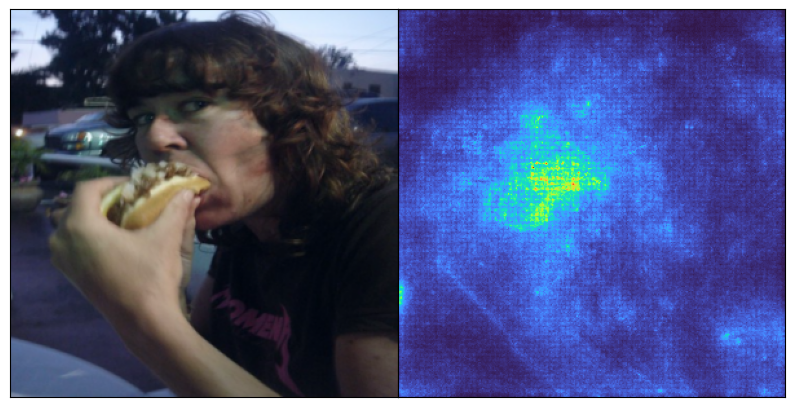

In [88]:
plot_saliency_and_img(img, sal)

In [89]:
model.eval()

input = img.unsqueeze(0)
input.requires_grad = True

model(input.to(device))

tensor([[4.5834e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

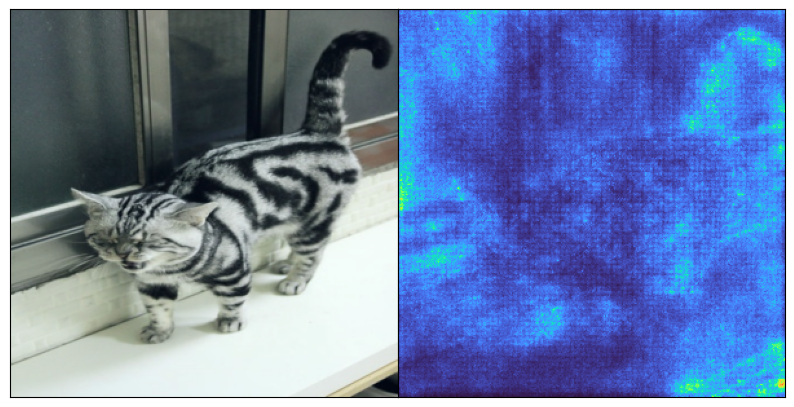

In [90]:
img = sample_images[3] 
sal= smoothgrad(img, 20, 0.1)

plot_saliency_and_img(img, sal)

In [28]:
model.eval()

input = img.unsqueeze(0)
input.requires_grad = True

model(input.to(device))

tensor([[0.9998]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [29]:
test_img = PIL.Image.open('hot_dog_hamster.png')

In [30]:
test_img.convert("RGB")
test_img = np.asarray(test_img, dtype=np.float32)/ 255
test_img = test_img[:, :, :3]

In [31]:
test_img = torch.tensor(test_img).permute(2, 0, 1)

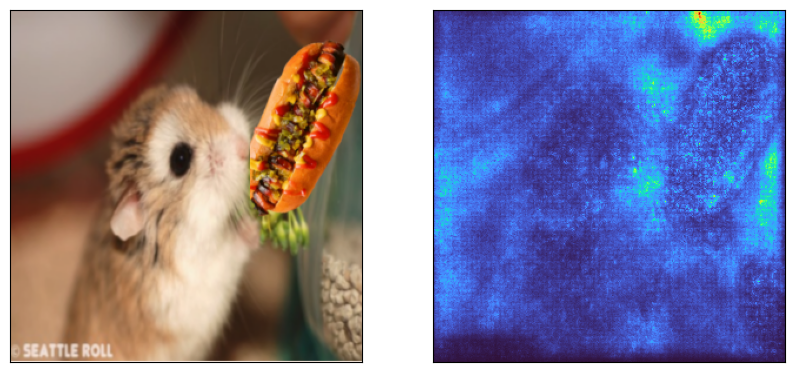

In [32]:
img = test_img
sal= smoothgrad(img, 20, 0.05)

plot_saliency_and_img(img, sal)

In [33]:
model.eval()

input = test_img.unsqueeze(0)
input.requires_grad = True

model(input.to(device))

tensor([[0.1165]], device='cuda:0', grad_fn=<SigmoidBackward0>)

# Train results

In [61]:
import pandas as pd

In [62]:
b = pd.read_csv('results/results_transfer_resnet_head_20_epochs_1e-03_lr_ADAMW_optim.csv')
w = pd.read_csv('results/results_transfer_resnet_full_20_epochs_1e-05_lr_ADAMW_optim.csv')

,train_acc,test_acc,train_loss,test_loss
0,0.862237,0.834586,0.322178,0.344267
1,0.899853,0.876477,0.231021,0.299548
2,0.899365,0.861976,0.226891,0.461617
3,0.921837,0.888292,0.193869,0.307590
4,0.922814,0.851772,0.181839,0.608448
5,0.944797,0.886681,0.151538,0.312548
6,0.949682,0.850161,0.120040,0.695402
7,0.949194,0.850161,0.137357,0.389656
8,0.943332,0.885070,0.151005,0.258934
9,0.956522,0.887218,0.112653,0.293465


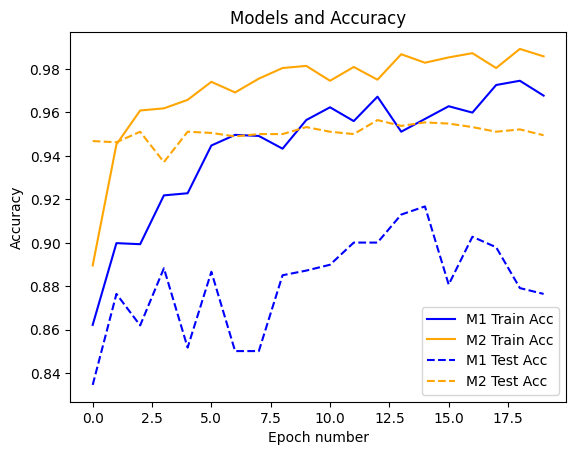

In [77]:
plt.plot(w['train_acc'], color='blue')
plt.plot(b['train_acc'], color='orange')

plt.plot(w['test_acc'], linestyle='dashed', color='blue')
plt.plot(b['test_acc'], linestyle='dashed', color='orange')

plt.legend(('M1 Train Acc','M2 Train Acc', 'M1 Test Acc','M2 Test Acc'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.title('Models and Accuracy')
plt.savefig('best.png')